In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, roc_auc_score

import xgboost as xgb
import lightgbm as lgb

In [2]:
train_df = pd.read_csv('/Users/allenzhang/Desktop/Career/dataset/shanshu/case2_training.csv')

In [3]:
train_df.head()

,ID,Region,Date,Weekday,Apartment,Beds,Review,Pic Quality,Price,Accept
0,1,4,32,5,1,1,4.526975,0.739994,230.552998,0
1,2,2,87,4,1,1,4.548455,0.862642,348.203425,0
2,3,5,277,5,1,2,4.965732,0.515548,430.462327,0
3,4,3,246,2,1,1,4.752735,0.561547,149.305433,1
4,5,1,155,2,1,2,3.890960,0.817142,165.264184,1


In [4]:
y = train_df['Accept']

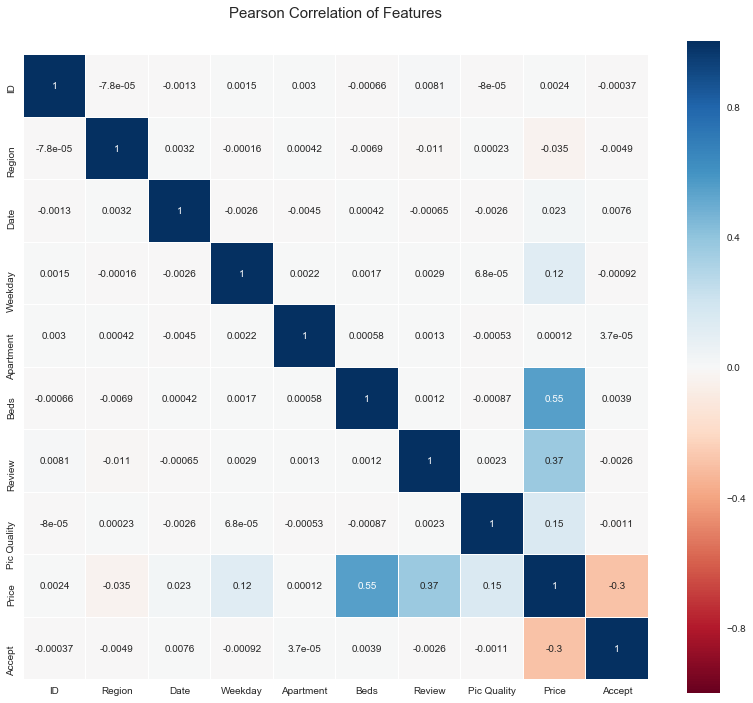

In [5]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

/usr/local/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


[Text(0,0.5,'Label'), Text(0.5,0,'Count')]

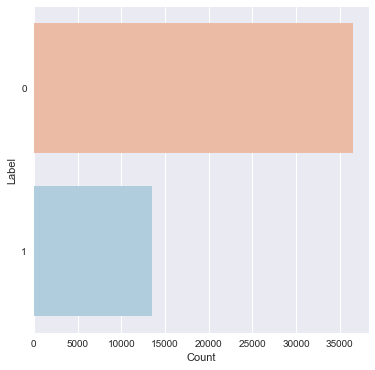

In [6]:
# -------------------------------------------- 
# VISUALISE LABELS AND FREQUENCIES (BAR CHART)
# --------------------------------------------
sns.set_style("whitegrid", {'axes.grid' : True})
plt.figure(figsize=(6,6))
sns.set(style='darkgrid')
ax_label = sns.countplot(y = y, palette="RdBu")
ax_label.set(ylabel = 'Label', xlabel = 'Count')

In [7]:
X = train_df.drop(['Accept'], axis=1)
X = X.drop('ID', axis=1)

normalized_X=(X-X.mean())/X.std()

In [8]:
features_name = X.columns.values
kf = KFold(n_splits=5)
X_train, X_vali, y_train, y_vali = train_test_split(X,y, test_size=0.2)

### Random Forest

In [9]:
%%time

acc_list = []
imp_list = []

random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

for train_index, vali_index in kf.split(X):
    X_train, X_vali = X.iloc[train_index], X.iloc[vali_index]
    y_train, y_vali = y[train_index], y[vali_index]
    random_forest.fit(X_train, y_train)
    acc_list.append(random_forest.score(X_vali, y_vali))
    
    # Extract feature importances
    imp_list.append(random_forest.feature_importances_)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.9s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.7s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jo

CPU times: user 46 s, sys: 1.2 s, total: 47.2 s
Wall time: 18.2 s


In [10]:
acc_rf = np.mean(acc_list)
imp_mean = np.mean(imp_list, axis = 0)
feature_importances = pd.DataFrame({'feature': features_name, 'importance': imp_mean})

print("The random forest 5-fold average accuracy is %3f" % acc_rf)

print("--------------------\nthe average 5-fold feature importances in random forest as follow: ")
print(feature_importances)

The random forest 5-fold average accuracy is 0.728620
--------------------
the average 5-fold feature importances in random forest as follow: 
       feature  importance
0       Region    0.077463
1         Date    0.150105
2      Weekday    0.057090
3    Apartment    0.015791
4         Beds    0.037711
5       Review    0.188092
6  Pic Quality    0.177244
7        Price    0.296504


#### Last fold ROC curve and AUC score

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


AUC is 0.763927


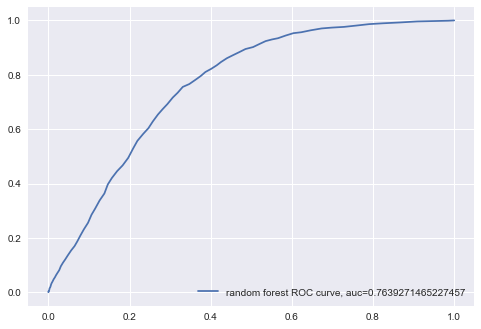

In [11]:
y_pred = random_forest.predict_proba(X_vali)

fpr, tpr, _ = roc_curve(y_vali,  y_pred[:,1])
auc = roc_auc_score(y_vali,  y_pred[:,1])

print("AUC is %4f" % auc)

plt.plot(fpr,tpr,label="random forest ROC curve, auc="+str(auc))
plt.legend(loc=4);

## Others

#### Logistic Regression Model

In [12]:
%%time
lr_clf = LogisticRegression(penalty='l2', max_iter=500, verbose=1)

lr_clf.fit(X_train, y_train)
print(lr_clf.score(X_vali, y_vali))
print("------------------------\ntime data as follow:")

[LibLinear]0.7447
------------------------
time data as follow:
CPU times: user 253 ms, sys: 13.9 ms, total: 267 ms
Wall time: 265 ms


LR AUC is 0.769833


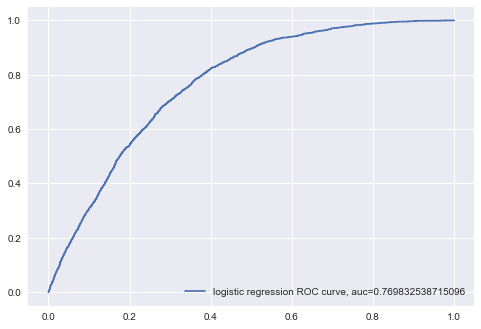

In [13]:
lr_pred_prob = lr_clf.predict_proba(X_vali)
lr_fpr, lr_tpr, _ = roc_curve(y_vali,  lr_pred_prob[:,1])
lr_auc = roc_auc_score(y_vali,  lr_pred_prob[:,1])

print("LR AUC is %4f" % lr_auc)

plt.plot(lr_fpr, lr_tpr, label="logistic regression ROC curve, auc="+str(lr_auc))
plt.legend(loc=4);

In [14]:
%%time
SVM_clf = SVC(verbose=1)

SVM_clf.fit(X_train, y_train)
print(SVM_clf.score(X_vali, y_vali))
print("------------------------\ntime data as follow:")

[LibSVM]0.7268
------------------------
time data as follow:
CPU times: user 1min 54s, sys: 1.73 s, total: 1min 56s
Wall time: 1min 59s


#### XgBoosing Model

In [15]:
%%time
gbm = xgb.XGBClassifier(
        learning_rate = 0.02,
        n_estimators= 2000,
        max_depth= 4,
        min_child_weight= 2,
        #gamma=1,
        gamma=0.9,                        
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread= -1,
        scale_pos_weight=1).fit(X_train, y_train)
xgb_pred = gbm.predict(X_vali)
xgb_acc = np.sum(xgb_pred == list(y_vali)) / len(y_vali)
print("XgBoost accuracy is %3f" % xgb_acc)
print("------------------------\ntime data as follow:")

XgBoost accuracy is 0.743800
------------------------
time data as follow:
CPU times: user 37.1 s, sys: 270 ms, total: 37.4 s
Wall time: 38.1 s


/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### Gradient Boosting Machine: LGB Model

In [16]:
%%time
lgb_model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
lgb_model.fit(X_train, y_train)

lgb_pred = lgb_model.predict(X_vali)
lgb_acc = np.sum(lgb_pred == list(y_vali)) / len(y_vali)
print("XgBoost accuracy is %3f" % xgb_acc)
print("------------------------\ntime data as follow:")

XgBoost accuracy is 0.743800
------------------------
time data as follow:
CPU times: user 1min 30s, sys: 51.9 s, total: 2min 21s
Wall time: 1min 7s


/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


LGB AUC is 0.743772


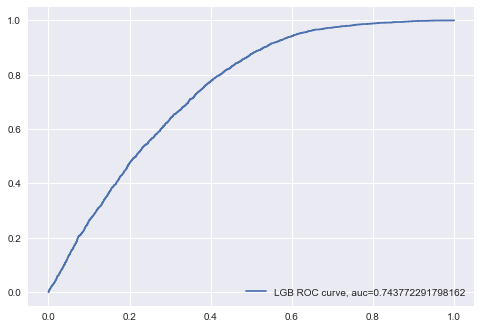

In [17]:
lgb_pred_prob = lgb_model.predict_proba(X_vali)

lgb_fpr, lgb_tpr, _ = roc_curve(y_vali,  lgb_pred_prob[:,1])
lgb_auc = roc_auc_score(y_vali,  lgb_pred_prob[:,1])

print("LGB AUC is %4f" % lgb_auc)

plt.plot(lgb_fpr, lgb_tpr, label="LGB ROC curve, auc="+str(lgb_auc))
plt.legend(loc=4);